In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
from NetEmbs.DataProcessing.normalize import normalize
from NetEmbs.GenerateData.complex_df import sales_collections
d=normalize(sales_collections())

In [4]:
from NetEmbs.FSN.graph import FSN

In [5]:
fsn = FSN()
fsn.build(d)
fsn.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 'Revenue', 'Tax', 'Trade Receivables', 'Cash'))

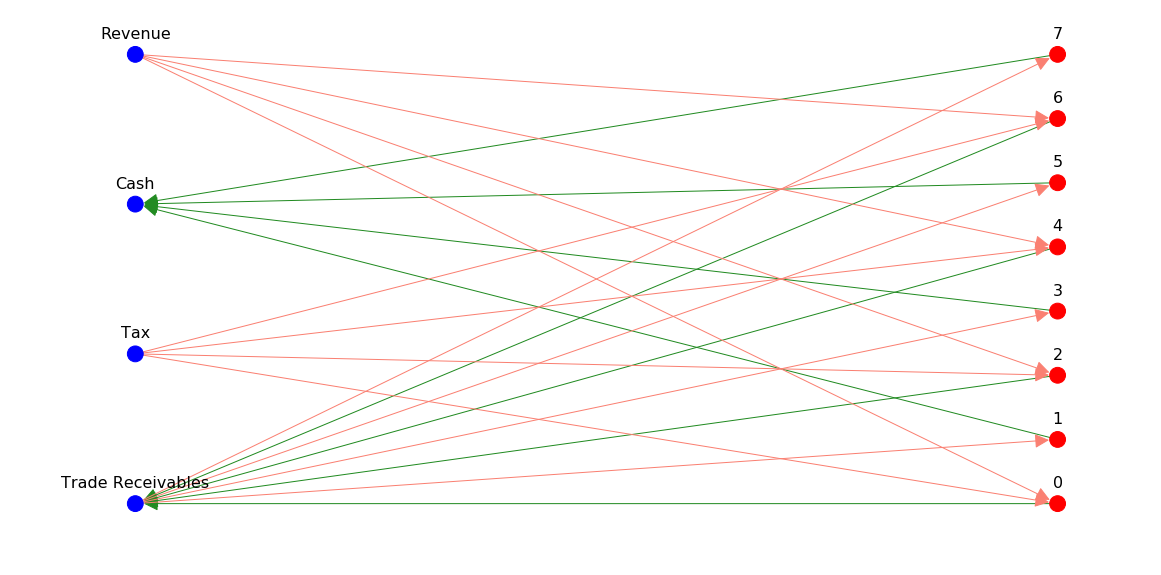

In [6]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(fsn)

## Different sampling strategies

In [ ]:
from scipy.special import softmax
def def_step(G, vertex, direction="IN", weighted=False, debug=False, **kwargs):
#     One step according to the original implementation of RandomWalk by Perozzi et al.
    if vertex==-1:
#         Step cannot be made, return -1
        return -1
    elif not G.has_node(vertex):
        raise ValueError("Vertex {!r} is not in FSN!".format(vertex))
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        raise ValueError("Wrong direction argument! {!s} used while IN or OUT are allowed!".format(direction))
    indexes = ["IN", "OUT"]
    if len(ins) > 0:
        if weighted:
            ws = list()
            tmp_vertex = None
            tmp_weight = None
            ws = [edge[-1]["weight"] for edge in ins]
            p_ws = ws / np.sum(ws)
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
            tmp_vertex = ins[tmp_idx]
            tmp_weight = ws[tmp_idx]
        else:
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_vertex = np.random.choice(ins)
        if debug:
            print(tmp_vertex)
        return tmp_vertex
    else:
        return -1

In [ ]:
cur=1
for _ in range(10):
    cur = def_step(fsn, cur)
    print(cur)

In [14]:
from NetEmbs.FSN.utils import def_step, step
# Default sampling with RandomWalk: follow the direction, uniform transition probability etc.
def randomWalk(G, vertex=None, lenght=3, direction="IN", mode="meta_new", weighted=False, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            if mode=="def":
                new_v = def_step(G, cur_v, direction, weighted, debug=debug)
            elif mode=="meta_def":
                if weighted:
                    new_v = step(G, cur_v, direction, mode=1, debug=debug)
                else:
                    new_v = step(G, cur_v, direction, mode=0, debug=debug)
            elif mode=="meta_new":
                new_v = step(G, cur_v, direction, mode=2, debug=debug)
            attempts-=1
        except nx.NetworkXError:
            break
        if new_v == -1:
            if debug: print("Cannot continue walking... Termination.")
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [25]:
randomWalk(fsn, 6, 50, mode="meta_new")

[6, 4, 6, 4, 2, 0, 4, 0, 2, 6, 0]